# Cinétique chimique - Problèmes raides

On s’intéresse à l’oxydation du sulfite de cuivre : il s’agit d’une réaction d’autocatalyse dont l’étude cinétique conduit à un problème différentiel raide. On étudie différentes méthodes numériques pour en approcher la solution. Cette présentation est inspirée du polycopié d'Analyse Numérique d'Ernst Hairer (et adapté d'un TP donné à Rennes par Grégory Vial).

Mettez ci-dessous les imports classiques de librairie Python

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Le modèle
La cinétique chimique s’intéresse aux aspects temporels liés aux réactions chimiques. Les problèmes les plus intéressants sont ceux dans lesquels plusieurs réactions ont lieu simultanément ou successivement, avec des vitesses de différents ordres de grandeur. C’est souvent le cas lors de réactions d’autocatalyse.
Le phénomène d’oxydation du sulfite de cuivre est un exemple d’autocatalyse. En effet, le sulfite de cuivre ne réagit pas directement avec le dioxygène, mais produit lui-même le catalyseur qui va permettre la réaction. L’équation bilan s’écrit
$$
Cu\ SO_3 + \frac{1}{2} O_2 \longrightarrow Cu\ S O_4
$$
En réalité le mécanisme chimique est beaucoup plus complexe, un modèle simplifié est le suivant :
$$
\begin{array}{lcl}
Cu^{2+} + SO^{2−}_3 & \rightleftharpoons & Cu^+ + SO_3^- \\
Cu^+ + SO^−_3 + \frac{1}{2} O_2 & \rightarrow & Cu^+ + SO^−_4
\end{array}
$$
La première réaction favorise fortement le sens de droite à gauche car le sulfite de cuivre est un composé stable. D’autre part, la seconde est très rapide, ce qui permet l’oxydation même si le catalyseur est en très faible quantité.
Le prototype de ce genre d'équations est donné par le problème de Robertson (1966) : les quantités chimiques en jeu sont appelées A, B, C pour plus de simplicité ; le bilan global de la réaction est $A \to C$. On décompose le mécanisme chimique complexe en trois réactions élémentaires dont les lois cinétiques sont supposées d’ordre 1 :
$$
\begin{array}{cccl}
A & \longrightarrow &  B & (\text{lente : } k_1 = 0.04),\\
B+B & \longrightarrow & C+B &(\text{très rapide : } k_2 =3.10^7),\\ 
B+C & \longrightarrow & A+C &(\text{rapide : } k_3 =10^4).
\end{array}
$$
La première réaction est nommée *amorçage*, il s’agit de la formation lente du catalyseur $B$. Le deuxième réaction produit le composé $C$ très rapidement, et la troisième traduit la recomposition du catalyseur B (*rupture*) ; cette dernière justifie le terme d’autocatalyse.
Les vitesses des trois réactions en jeu sont très différentes comme le montrent les constantes de réaction situées à droite des équations chimiques. Les lois de la cinétique chimique permettent d’obtenir le système différentiel suivant, où $y_a(t),y_b(t),y_c(t)$ désignent les quantités respectives des composés $A$, $B$ et $C$ à l'instant $t$,

$$
\left \{
\begin{array}{lclll}
y_a'(t) & = & - k_1 y_a(t) & + k_3y_b(t)y_c(t),\\
y_b'(t) & = & \phantom{-} k_1 y_a(t)  & - k_3y_b(t)y_c(t)  & - k_2[y_b(t)]^2,\\
y_c'(t) & = & & & \phantom{-} k_2[y_b(t)]^2.
\end{array}
\right.
$$

Ces équations sont assorties de conditions initiales, traduisant la seule présence du réactif $A$:
$$
y_a(0)=1, \ y_b(0)=0, \ y_c(0) =0.
$$

Résoudre numériquement le système sur l'intervalle $[0,T]$ à l'aide de la méthode d'Euler explicite. On prendra $T=0.3$ et on testera avec $dt=10^{-3}$, puis $dt=10^{-4}$. Tracez les solutions séparément pour $y_a$, $y_b$ et $y_c$ et commentez.

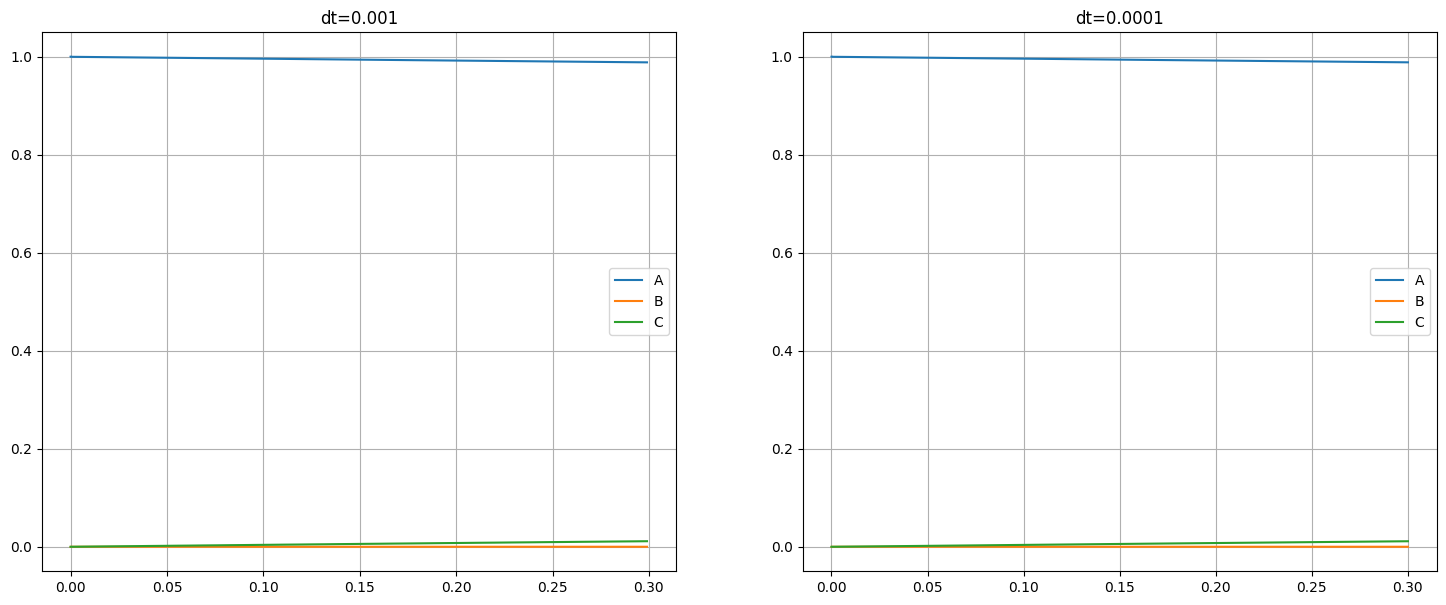

In [8]:
# Parameters
k1 = 0.04
k2 = 3e7
k3 = 1e4

# Function f
def f(x): # x is in R^3
    t1 = k1*x[0]
    t2 = k3*x[1]*x[2]
    t3 = k2*x[1]**2

    return np.array([-t1+t2, t1-t2-t3, t3])

# Euler explicit
def EulerExpicit(x, dt, f):
    return x + dt*f(x)

# Solver
def solve_system(init, dt, T, schema, f):
    current_t = 0.0
    current_X = init
    history_t = [current_t]
    history_X = [current_X]

    while current_t < T:
        current_X = schema(current_X, dt, f)

        history_X.append(current_X)
        
        history_t.append(current_t)
    
        if np.max(np.abs(current_X)) > 1000:
            print(f"Instability detected at t={current_t:.7} with dt={dt}")
            break

        current_t += dt
    
    return np.array(history_X), np.array(history_t)


T = 0.3
dt1 = 1e-3
dt2 = 1e-4
Xdt1 = np.array([1.0, 0.0, 0.0])
Xdt2 = np.array([1.0, 0.0, 0.0])

Xdt1, t1 = solve_system(Xdt1, dt1, T, EulerExpicit, f)
Xdt2, t2 = solve_system(Xdt2, dt2, T, EulerExpicit, f)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
ax1.set_title(f"dt={dt1}")
ax1.plot(t1, Xdt1[:, 0], label="A")
ax1.plot(t1, Xdt1[:, 1], label="B")
ax1.plot(t1, Xdt1[:, 2], label="C")
ax1.legend()
ax1.grid(True)

ax2.set_title(f"dt={dt2}")
ax2.plot(t2, Xdt2[:, 0], label="A")
ax2.plot(t2, Xdt2[:, 1], label="B")
ax2.plot(t2, Xdt2[:, 2], label="C")
ax2.legend()
ax2.grid(True)

plt.show()

Afin de comprendre pourquoi la solution est mal calculée quand $dt$ est trop grand, on étudie le problème simplifié suivant:
$$\left\{\begin{array}{ll}
y'(t) = -\lambda y(t)), \quad 0\leq t\leq t_{\textrm{fin}},
\\ y(0) = 1.
\end{array}\right. \quad\quad\quad(1)$$
où $\lambda \in \mathbb{R}^{+*}$. On choisit $t_{\textrm{fin}}=1$ et $\lambda=20$.
Calculez la solution analytique du problème $(1)$.

On veut vérifier si la solution approchée de $(1)$ obtenue par le biais de différentes méthodes vérifie
$$
\lim_{t\to +\infty} y(t) =0\ \qquad (2).
$$
On considèrera les méthodes suivantes :
<li>La méthode d'Euler explicite: le passage de l'itéré $n-1$ à l'itéré $n$ se fait de la façon suivante:

$$ y_n = y_{n-1}+hf(y_{n-1}).$$</li>

<li>La méthode d'Euler implicite: le passage de l'itéré $n-1$ à l'itéré $n$ se fait de la façon suivante:

$$ y_n = y_{n-1}+hf(y_{n}).$$</li> 

<li>La méthode RK2: le passage de l'itéré $n-1$ à l'itéré $n$ se fait de la façon suivante:

$$\left\{\begin{array}{ll}
k_1 = f(y_{n-1}),
\\ k_2 = f(y_{n-1}+\frac h 2 k_1),
\\ y_n = y_{n-1} + h k_2.
\end{array}\right.$$</li>

<li>La méthode implicite des trapèzes (ou Crank-Nicolson): le passage de l'itéré $n-1$ à l'itéré $n$ se fait de la façon suivante:

$$ y_n = y_{n-1}+\frac h 2 \left(f(y_{n-1}) + f(y_{n})\right).$$</li>

Pour chacune d'entre elle, donner en fonction de $\lambda$ un critère sur le pas de temps $h$ pour que $(2)$ soit vérifié.

Vérifier numériquement pour l'équation $(1)$ le comportement de ces solutions.

Suite aux résultats précédents, résoudre le problème de cinétique chimique par la méthode d'Euler implicite avec $dt=10^{-3}$ et $10^{-2}$. Faire de même avec les méthodes RK2 et de Crank-Nicolson. Commentez.